In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp

In [15]:
class monkey_saddle_func(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return x**3 - 3 * x * y**2


x, y = sp.symbols("x y")
r_min, r_max = -10.0, 10.0
# sample input range uniformly at 0.1 increments
xaxis = np.arange(r_min, r_max, 0.1)
yaxis = np.arange(r_min, r_max, 0.1)
# create a mesh from the axis
x_vals, y_vals = np.meshgrid(xaxis, yaxis)
f_lam_msf = sp.lambdify((x, y), monkey_saddle_func(x, y), modules=["numpy"])
z_vals_msf = f_lam_msf(x_vals, y_vals)

In [2]:
class hyperbolic_paraboloid_func(sp.Function):
    @classmethod
    def eval(cls, x, y):
        return sp.tanh(x**2 - y**2)


x, y = sp.symbols("x y")
r_min, r_max = -10.0, 10.0
# sample input range uniformly at 0.1 increments
xaxis = np.arange(r_min, r_max, 0.1)
yaxis = np.arange(r_min, r_max, 0.1)
# create a mesh from the axis
x_vals, y_vals = np.meshgrid(xaxis, yaxis)
f_lam_hpf = sp.lambdify(
    (x, y), hyperbolic_paraboloid_func(x, y), modules=["numpy"])
z_vals_hpf = f_lam_hpf(x_vals, y_vals)

In [3]:
def gradintdescent(
    funct, learning_rate: float = 0.01, iterit: int = 100, init_val: dict = {}
):
    varis = sorted(funct.free_symbols, key=lambda s: s.name)
    f_grad = sp.Matrix([funct.diff(var) for var in varis])
    f_lam = sp.lambdify(args=[tuple(varis)], expr=funct, modules=["numpy"])
    input_dict = {var: [val] for var, val in zip(varis, init_val.values())}
    rand_val_dict = {var: [val] for var, val in zip(varis, init_val.values())}

    pbest_list = np.zeros(shape=(1, len(varis)))
    gbest_list = np.zeros(shape=(1, len(varis)))
    gbest_val = np.zeros(shape=len(varis))
    v_val = np.zeros(shape=len(varis))
    while iterit != 1:
        f_res = np.array(funct.subs(init_val)).astype(float).T.flatten()[0]
        rand_val_dict = {
            var: np.random.default_rng(iterit + i)
            .uniform(-1 + val, 1 + val, (10, 1))
            .flatten()
            for var, val, i in zip(
                init_val.keys(), init_val.values(), range(len(init_val.keys()))
            )
        }
        randf_val = np.array(list(rand_val_dict.values())).T
        randf_res = f_lam(randf_val.T)
        pbest_val = randf_val[np.argmin(randf_res)]
        pbest_res = f_lam(randf_val[np.argmin(randf_res)])
        gbest_res = np.min(np.array([pbest_res, f_lam(gbest_val), f_res]))
        print("f_res_{} ".format(200 - iterit + 1), f_res)
        print("pbest_res_{} ".format(200 - iterit + 1), pbest_res)
        print("gbest_res_{} ".format(200 - iterit + 1), f_lam(gbest_val))
        print("gbest_res_brfore{} ".format(200 - iterit + 1), gbest_res)
        if gbest_res == f_res:
            gbest_val = np.array(list(init_val.values()))
        elif float(gbest_res) == pbest_res:
            gbest_val = pbest_val
        else:
            gbest_val = gbest_val
        print("gbest_res_after{} ".format(200 - iterit + 1), f_lam(gbest_val))

        v_val = (
            0.9 * v_val
            + 1.1 * (gbest_val - np.array(list(init_val.values())))
            + 0.9 * (pbest_val - np.array(list(init_val.values())))
        )
        print("v_val_{} ".format(200 - iterit + 1), v_val)
        print("init_val_{} ".format(200 - iterit + 1), list(init_val.values()))
        init_val_m = {
            var: val + v_val
            for var, val, v_val in zip(varis, list(init_val.values()), v_val)
        }
        grad_val_m = np.array(f_grad.subs(init_val_m)).astype(float).T.flatten()

        init_val_list = list(init_val_m.values()) - learning_rate * grad_val_m
        init_val = {var: val for var, val in zip(varis, init_val_list)}
        if not all(abs(x) < 10 for x in np.array(list(init_val.values()))):
            print(
                "\033[1m"
                + "\033[31m"
                + "early stopping becuse cross the limition"
                + "\033[0m"
                + "\033[0m",
                end="\n",
            )
            break
        input_dict = {
            var: input_dict[var] + [val] for var, val in zip(varis, init_val.values())
        }
        iterit -= 1
        pbest_list = np.append(pbest_list, pbest_val.reshape(1, 2), axis=0)
        gbest_list = np.append(gbest_list, gbest_val.reshape(1, 2), axis=0)

    return (
        {str(key): np.array(value) for key, value in input_dict.items()},
        pbest_list,
        gbest_list,
        iterit,
    )

In [ ]:
def momentum(
    funct,
    learning_rate: float = 0.01,
    iter: int = 100,
    init_val: dict = {},
    beta0: list = [0.9, 0.9],
    m0: list = [0, 0],
):
    varis = sorted(funct.free_symbols, key=lambda s: s.name)
    f_grad = sp.Matrix([funct.diff(var) for var in varis])
    input_dict = {var: [val] for var, val in zip(varis, init_val.values())}
    m = np.array(m0)
    beta = np.array(beta0)

    while iter != 1:
        grad_val = np.array(f_grad.subs(init_val)).astype(float).T.flatten()
        m = beta * m - learning_rate * grad_val
        init_val_list = np.array(list(init_val.values())) + m
        init_val = {var: val for var, val in zip(varis, init_val_list)}
        if not all(abs(x) < 5 for x in np.array(list(init_val.values()))):
            print(
                "\033[1m"
                + "\033[31m"
                + "early stopping becuse cross the limition"
                + "\033[0m"
                + "\033[0m",
                end="\n",
            )
            break
        input_dict = {
            var: input_dict[var] + [val] for var, val in zip(varis, init_val.values())
        }
        iter -= 1

    return {str(key): np.array(value) for key, value in input_dict.items()}

In [ ]:
def nesterovaccgradient(
    funct,
    learning_rate: float = 0.01,
    iter: int = 100,
    init_val: dict = {},
    beta0: list = [0.9, 0.9],
    m0: list = [0, 0],
):
    varis = sorted(funct.free_symbols, key=lambda s: s.name)
    f_grad = sp.Matrix([funct.diff(var) for var in varis])
    input_dict = {var: [val] for var, val in zip(varis, init_val.values())}
    m = np.array(m0)
    beta = np.array(beta0)
    while iter != 1:
        mb = m * beta
        init_val = {
            key: var + float(mb[i])
            for i, key, var in zip(range(len(mb)), varis, init_val.values())
        }
        grad_val = np.array(f_grad.subs(init_val)).astype(float).T.flatten()
        m = mb - learning_rate * grad_val
        init_val_list = np.array(list(init_val.values())) + m
        init_val = {var: val for var, val in zip(varis, init_val_list)}
        if not all(abs(x) < 5 for x in np.array(list(init_val.values()))):
            print(
                "\033[1m"
                + "\033[31m"
                + "early stopping becuse cross the limition"
                + "\033[0m"
                + "\033[0m",
                end="\n",
            )
            break
        input_dict = {
            var: input_dict[var] + [val] for var, val in zip(varis, init_val.values())
        }
        iter -= 1

    return {str(key): np.array(value) for key, value in input_dict.items()}

In [ ]:
def adagrad(
    funct,
    learning_rate: float = 0.01,
    iter: int = 100,
    init_val: dict = {},
    epsilon: float = 1e-8,
    s0: list = [0, 0],
):
    varis = sorted(funct.free_symbols, key=lambda s: s.name)
    f_grad = sp.Matrix([funct.diff(var) for var in varis])
    input_dict = {var: [val] for var, val in zip(varis, init_val.values())}
    s = np.array(s0)
    while iter != 1:
        grad_val = np.array(f_grad.subs(init_val)).astype(float).T.flatten()
        s = s + grad_val**2
        init_val_list = np.array(list(init_val.values())) - learning_rate * grad_val / (
            (s + epsilon) ** 0.05
        )
        init_val = {var: val for var, val in zip(varis, init_val_list)}
        if not all(abs(x) < 5 for x in np.array(list(init_val.values()))):
            print(
                "\033[1m"
                + "\033[31m"
                + "early stopping becuse cross the limition"
                + "\033[0m"
                + "\033[0m",
                end="\n",
            )
            break
        input_dict = {
            var: input_dict[var] + [val] for var, val in zip(varis, init_val.values())
        }
        iter -= 1

    return {str(key): np.array(value) for key, value in input_dict.items()}

In [ ]:
def RMSProp(
    funct,
    learning_rate: float = 0.01,
    iter: int = 100,
    init_val: dict = {},
    epsilon: float = 1e-8,
    s0: list = [0, 0],
    rho0: list = [0.9, 0.9],
):
    varis = sorted(funct.free_symbols, key=lambda s: s.name)
    f_grad = sp.Matrix([funct.diff(var) for var in varis])
    input_dict = {var: [val] for var, val in zip(varis, init_val.values())}
    s = np.array(s0)
    rho = np.array(rho0)
    while iter != 1:
        grad_val = np.array(f_grad.subs(init_val)).astype(float).T.flatten()
        s = rho * s + (1 - rho) * grad_val**2
        init_val_list = np.array(list(init_val.values())) - learning_rate * grad_val / (
            (s + epsilon) ** 0.05
        )
        init_val = {var: val for var, val in zip(varis, init_val_list)}
        if not all(abs(x) < 5 for x in np.array(list(init_val.values()))):
            print(
                "\033[1m"
                + "\033[31m"
                + "early stopping becuse cross the limition"
                + "\033[0m"
                + "\033[0m",
                end="\n",
            )
            break
        input_dict = {
            var: input_dict[var] + [val] for var, val in zip(varis, init_val.values())
        }
        iter -= 1

    return {str(key): np.array(value) for key, value in input_dict.items()}

In [ ]:
def adam(
    funct,
    learning_rate: float = 0.01,
    iter: int = 100,
    init_val: dict = {},
    epsilon: float = 1e-8,
    s0: list = [0, 0],
    m0: list = [0, 0],
    beta10: list = [0.9, 0.9],
    beta20: list = [0.99, 0.99],
):
    varis = sorted(funct.free_symbols, key=lambda s: s.name)
    f_grad = sp.Matrix([funct.diff(var) for var in varis])
    input_dict = {var: [val] for var, val in zip(varis, init_val.values())}
    s = np.array(s0)
    m = np.array(m0)
    beta1 = np.array(beta10)
    beta2 = np.array(beta20)
    t = 1
    while iter != 1:
        grad_val = np.array(f_grad.subs(init_val)).astype(float).T.flatten()
        m = beta1 * m - (1 - beta1) * grad_val
        s = beta2 * s + (1 - beta2) * grad_val**2
        m_hat = 1 / (1 - beta1**t)
        s_hat = 1 / (1 - beta2**t)
        init_val_list = np.array(
            list(init_val.values())
        ) - m_hat * learning_rate * grad_val / (s_hat**0.05 + epsilon)
        init_val = {var: val for var, val in zip(varis, init_val_list)}
        if not all(abs(x) < 5 for x in np.array(list(init_val.values()))):
            print(
                "\033[1m"
                + "\033[31m"
                + "early stopping becuse cross the limition"
                + "\033[0m"
                + "\033[0m",
                end="\n",
            )
            break
        input_dict = {
            var: input_dict[var] + [val] for var, val in zip(varis, init_val.values())
        }
        t += 1
        iter -= 1

    return {str(key): np.array(value) for key, value in input_dict.items()}

In [16]:
res_gd_hpf, pbest, gbest, iterit = gradintdescent(
    funct=monkey_saddle_func(x, y),
    learning_rate=0.5,
    iterit=200,
    init_val={x: 0, y: 0},
)
z_res_gd_hpf = f_lam_hpf(res_gd_hpf["x"], res_gd_hpf["y"])

f_res_1  0.0
pbest_res_1  -0.8295719632777461
gbest_res_1  0.0
gbest_res_brfore1  -0.8295719632777461
gbest_res_after1  -0.8295719632777461
v_val_1  [-1.88039339 -0.04663461]
init_val_1  [0, 0]
f_res_2  -369.2840025114509
pbest_res_2  -519.9575089259113
gbest_res_2  -0.8295719632777461
gbest_res_brfore2  -519.9575089259113
gbest_res_after2  -519.9575089259113
v_val_2  [-3.41322467 -0.54499989]
init_val_2  [-7.180950163655103, 0.21643960518535094]
early stopping becuse cross the limition


In [ ]:
aaaaaaaa = np.random.default_rng(seed=10).uniform(-1, 1, (10, 2))
bbbbbbbbbb = np.array(f_lam_hpf(aaaaaaaa[:, 0], aaaaaaaa[:, 1]))
print(bbbbbbbbbb)
print(
    f_lam_hpf(
        aaaaaaaa[np.argmin(bbbbbbbbbb),
                 :0][0], aaaaaaaa[np.argmin(bbbbbbbbbb), :][1]
    )
)

In [ ]:
res_gd_hpf, randf, pbest, gbest, iter = gradintdescent(
    funct=monkey_saddle_func(x, y),
    learning_rate=0.5,
    iter=200,
    init_val={x: -5, y: 0.01},
)
z_res_gd_hpf = f_lam_hpf(res_gd_hpf["x"], res_gd_hpf["y"])

In [ ]:
z_res_gd_hpf

In [ ]:
res_gd_hpf["x"]

In [ ]:
randf[:, 0].shape

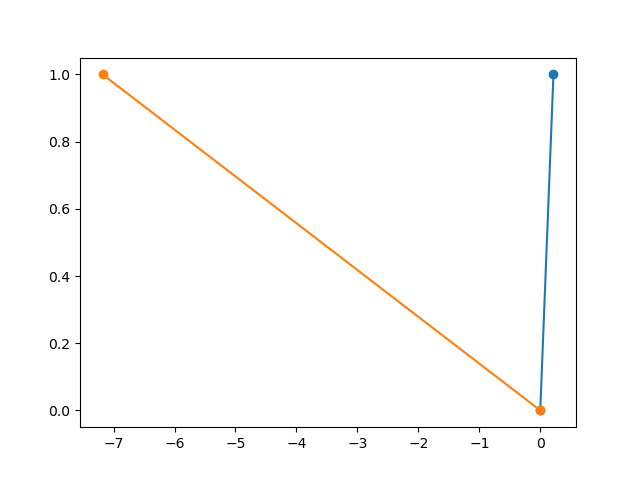

In [17]:
plt.close("all")
plt.plot(res_gd_hpf["y"], z_res_gd_hpf, "-o")
plt.plot(res_gd_hpf["x"], z_res_gd_hpf, "-o")
plt.show()

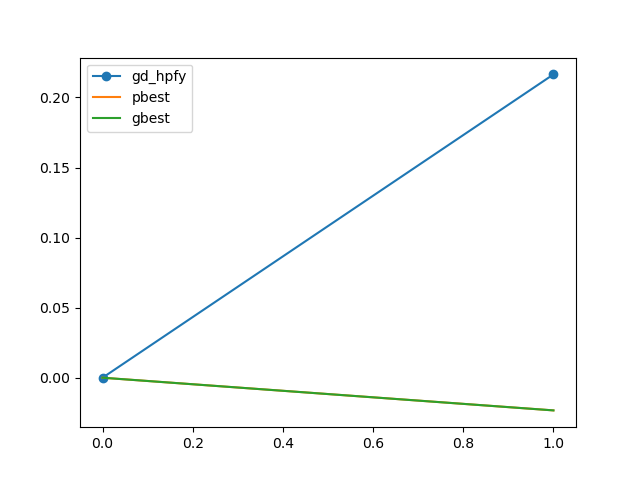

In [18]:
plt.close("all")
plt.plot(list(range(0, 200 - iterit + 1)), res_gd_hpf["y"], "-o")
plt.plot(list(range(0, 200 - iterit + 1)), pbest[:, 1])
plt.plot(list(range(0, 200 - iterit + 1)), gbest[:, 1])
plt.legend(["gd_hpfy", "pbest", "gbest"])
plt.show()

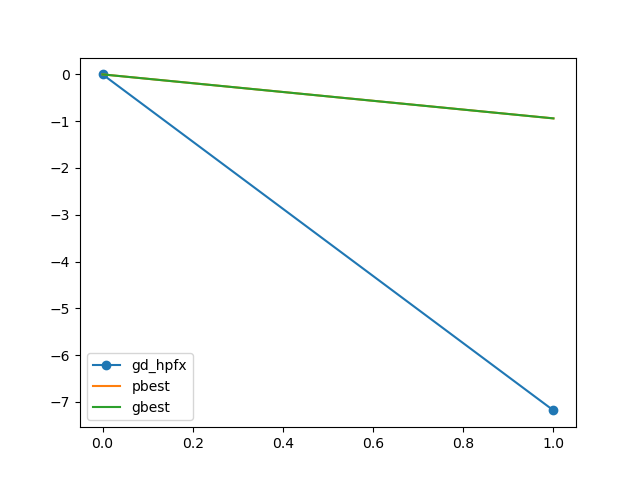

In [19]:
plt.close("all")
plt.plot(list(range(0, 200 - iterit + 1)), res_gd_hpf["x"], "-o")
plt.plot(list(range(0, 200 - iterit + 1)), pbest[:, 0])
plt.plot(list(range(0, 200 - iterit + 1)), gbest[:, 0])
plt.legend(["gd_hpfx", "pbest", "gbest"])
plt.show()

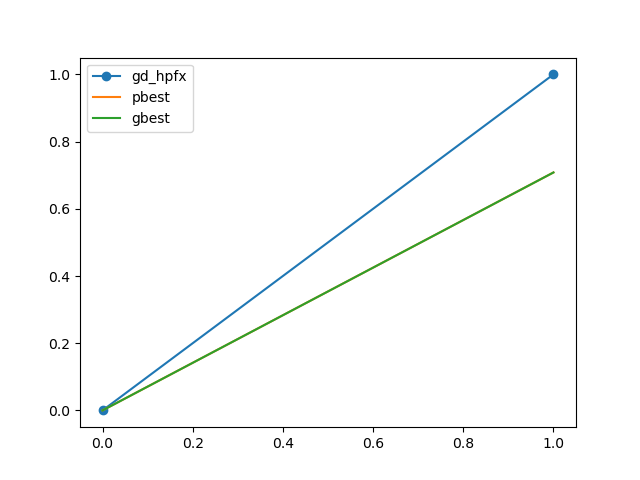

In [20]:
plt.close("all")
plt.plot(list(range(0, 200 - iterit + 1)), z_res_gd_hpf, "-o")
plt.plot(list(range(0, 200 - iterit + 1)), f_lam_hpf(pbest[:, 0], pbest[:, 1]))
plt.plot(list(range(0, 200 - iterit + 1)), f_lam_hpf(gbest[:, 0], gbest[:, 1]))
plt.legend(["gd_hpfx", "pbest", "gbest"])
plt.show()

In [ ]:
randf

In [ ]:
randf

In [ ]:
res_m_hpf = momentum(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.1,
    iter=200,
    init_val={x: 2, y: 0},
)
z_res_m_hpf = f_lam_hpf(res_m_hpf["x"], res_m_hpf["y"])

In [ ]:
res_nag_hpf = nesterovaccgradient(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.1,
    iter=200,
    init_val={x: 2, y: 0},
)
z_res_nag_hpf = f_lam_hpf(res_nag_hpf["x"], res_nag_hpf["y"])

In [ ]:
res_ag_hpf = adagrad(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.5,
    iter=200,
    init_val={x: 2, y: 0},
)
z_res_ag_hpf = f_lam_hpf(res_ag_hpf["x"], res_ag_hpf["y"])

In [ ]:
res_rmsp_hpf = RMSProp(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.5,
    iter=200,
    init_val={x: 2, y: 0},
    rho0=[0.9, 0.9],
)
z_res_rmsp_hpf = f_lam_hpf(res_rmsp_hpf["x"], res_rmsp_hpf["y"])

In [ ]:
res_adam_hpf = adam(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.5,
    iter=200,
    init_val={x: 2, y: 0},
)
z_res_adam_hpf = f_lam_hpf(res_adam_hpf["x"], res_adam_hpf["y"])

In [ ]:
res_rmsp_hpf_r_1 = RMSProp(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.5,
    iter=200,
    init_val={x: 2, y: 0},
    rho=[0, 0],
)
z_res_rmsp_hpf_r_1 = f_lam_hpf(res_rmsp_hpf_r_1["x"], res_rmsp_hpf_r_1["y"])

In [ ]:
res_rmsp_hpf_r_1 = RMSProp(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.5,
    iter=200,
    init_val={x: 2, y: 0},
    rho=[0, 0],
)
z_res_rmsp_hpf_r_1 = f_lam_hpf(res_rmsp_hpf_r_1["x"], res_rmsp_hpf_r_1["y"])

In [ ]:
plt.plot(list(range(0, 199)), np.diff(res_gd_hpf["x"]), "-o")
# plt.plot(list(range(0, 199)), np.diff(res_m_hpf["x"]), "-o")
plt.plot(list(range(0, 199)), np.diff(res_nag_hpf["x"]), "-o")
# plt.plot(list(range(0, 199)), np.diff(res_ag_hpf["x"]), "-o")
plt.plot(list(range(0, 199)), np.diff(res_rmsp_hpf["x"]), "-o")
plt.plot(list(range(0, 199)), np.diff(res_adam_hpf["x"]), "-o")
plt.legend(["GD", "NAG", "RMSP", "ADAM"])
plt.show()

In [ ]:
plt.plot(list(range(0, 50)), np.diff(res_rmsp_hpf["x"][0:51]), "-o")
plt.plot(list(range(0, 50)), np.diff(res_rmsp_hpf_r_05["x"][0:51]), "-o")
plt.plot(list(range(0, 50)), np.diff(res_rmsp_hpf_r_0["x"][0:51]), "-o")
plt.plot(list(range(0, 50)), np.diff(res_rmsp_hpf_r_1["x"][0:51]), "-o")
plt.legend(["hpf", "hpf_r_05", "hpf_r_0", "hpf_r_1"])
plt.show()

In [ ]:
plt.close("all")
plt.plot(list(range(0, 200)), res_gd_hpf["x"], "-o")
plt.plot(list(range(0, 200)), res_m_hpf["x"], "-o")
plt.plot(list(range(0, 200)), res_nag_hpf["x"], "-o")
plt.plot(list(range(0, 200)), res_ag_hpf["x"], "-o")
plt.plot(list(range(0, 200)), res_rmsp_hpf["x"], "-o")
plt.plot(list(range(0, 200)), res_adam_hpf["x"], "-o")
plt.legend(["GD", "M", "NAG", "AG", "RMSP", "ADAM"])
plt.show()

In [ ]:
plt.plot(res_gd_hpf["x"], z_res_gd_hpf, "-o")
plt.plot(res_m_hpf["x"], z_res_m_hpf, "-o")
plt.plot(res_nag_hpf["x"], z_res_nag_hpf, "-o")
plt.plot(res_ag_hpf["x"], z_res_ag_hpf, "-o")
plt.plot(res_rmsp_hpf["x"], z_res_rmsp_hpf, "-o")

plt.legend(["GD", "M", "NAG", "AG", "RMSP"])
plt.show()

In [ ]:
np.array(list(res_gd_hpf.values()))[0, 0]

In [ ]:
len(list(res_gd_hpf.values())[0])

In [ ]:
%matplotlib widget
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")




xs = x_vals
ys = y_vals
zs = z_vals_hpf
ma = np.nanmax(z_vals_hpf)
norm = matplotlib.colors.Normalize(vmin = 0, vmax = ma, clip = True)
points=ax.scatter([], [], [], c='r', alpha = 1)
ax.plot_surface(xs, ys, zs, cmap='viridis_r', linewidth=0.3,
                       zorder=10,alpha=0.4, edgecolor = 'k', norm=norm)
def update(i):
    x_res = np.array(list(res_gd_hpf.values()))[0,i]
    y_res = np.array(list(res_gd_hpf.values()))[1,i]
    z_res = z_res_gd_hpf[i]
    points.set_offsets([x_res,y_res,z_res])
    return points

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ani = FuncAnimation(
    fig,
    update,
    interval=50,
    blit=True,
    repeat=False,
    frames=len(list(res_gd_hpf.values())[0]),
)
#ax.set_xlim(0,0)
plt.show()

In [ ]:
z_res_gd_hpf

In [ ]:
%matplotlib widget
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")                                  # creates figure window
#ax = plt.axes(xlim=(-10,10),ylim=(-10,10))



xs = x_vals
ys = y_vals
zs = z_vals_hpf
#ma = np.nanmax(z_vals_hpf)
#norm = matplotlib.colors.Normalize(vmin = 0, vmax = ma, clip = True)

#ax.plot_surface(xs, ys, zs, cmap='viridis_r', linewidth=0.3,zorder=10,alpha=0.4, edgecolor = 'k', norm=norm)
points=ax.scatter([], [],[] ,c='r', alpha = 1)
def update(i):
    x_res = np.array(list(res_gd_hpf.values()))[0,i]
    y_res = np.array(list(res_gd_hpf.values()))[1,i]
    z_res = z_res_gd_hpf[i]
    points._offsets3d = (x_res,y_res,z_res)
    

ani = FuncAnimation(
    fig,
    update,
    interval=50,
    frames=len(list(res_gd_hpf.values())[0]),
)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(0,0)
plt.show()

In [ ]:
plt.close("all")

In [ ]:
plt.close("all")
from matplotlib.animation import FuncAnimation
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
plt.rcParams["figure.figsize"] = 4, 3

r = 1  # radius of circle


def circle(phi):
    return np.array([r * np.cos(phi), r * np.sin(phi)])


# create a figure with an axes
fig, ax = plt.subplots()
# set the axes limits
ax.axis([-1.5, 1.5, -1.5, 1.5])
# set equal aspect such that the circle is not shown as ellipse
ax.set_aspect("equal")
# create a point in the axes
(point) = ax.scatter([0], [0], marker="o")

# Updating function, to be repeatedly called by the animation


def update(phi):
    # obtain point coordinates
    x, y = circle(phi)
    # set point's coordinates
    point.set_offsets([x,y])
    


# create animation with 10ms interval, which is repeated,
# provide the full circle (0,2pi) as parameters
ani = FuncAnimation(
    fig,
    update,
    interval=10,
    blit=True,
    repeat=False,
    frames=np.linspace(0, 2 * np.pi, 360, endpoint=False),
)

plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
%matplotlib widget

fig, ax = plt.subplots()

x_start, y_start = (0, 0)
x_end, y_end = (90, 90)

x_1, y_1 = 0, 0
x_2, y_2 = 90, 90

plt.xlim((0, 100))
plt.ylim((0,100))

x = np.linspace(x_1, x_2, 50)
y = np.linspace(y_1, y_2, 50)

sc_1 = ax.scatter([], [], color="green", zorder=4)
line, = ax.plot([], [], color="crimson", zorder=4)
sc_2 = ax.scatter([], [], color="gold", zorder=4)


def animate(i):
    ## plot scatter point
    sc_1.set_offsets([x_start, y_start])

    ## plot line
    line.set_data(x[:i], y[:i])

    ## plot scatter point
    if i == len(x):
        sc_2.set_offsets([x_end, y_end])

    return sc_1, line, sc_2

ani = animation.FuncAnimation(
    fig=fig, func=animate, interval=1, blit=True, save_count=50)


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
plt.close("all")
%matplotlib widget
dt = 0.005
n=20
L = 1
particles=np.zeros(n,dtype=[("position", float , 2),
                           ("velocity", float ,2),
                           ("force", float ,2),
                           ("size", float , 1)])
particles["position"]=np.random.uniform(0,L,(n,2));
particles["velocity"]=np.zeros((n,2));
particles["size"]=0.5*np.ones(n);

fig = plt.figure(figsize=(7,7))
ax = plt.axes(xlim=(0,L),ylim=(0,L))
print(particles["position"])
scatter=ax.scatter(particles["position"][:,0], particles["position"][:,1])

def update(frame_number):
   particles["force"]=np.random.uniform(-2,2.,(n,2));
   particles["velocity"] = particles["velocity"] + particles["force"]*dt
   particles["position"] = particles["position"] + particles["velocity"]*dt

   particles["position"] = particles["position"]%L
   scatter.set_offsets(particles["position"])
   return scatter,

#anim = FuncAnimation(fig, update, interval=10,frames=20)
#plt.show()

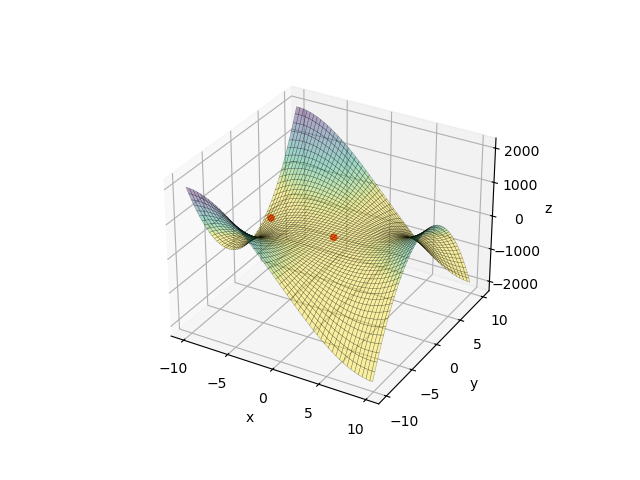

In [21]:
%matplotlib widget
plt.close("all")
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")


x_res = list(res_gd_hpf.values())[0]
y_res = list(res_gd_hpf.values())[1]
z_res = z_res_gd_hpf

xs = x_vals
ys = y_vals
zs = z_vals_msf
ma = np.nanmax(z_vals_msf)
norm = matplotlib.colors.Normalize(vmin = 0, vmax = ma, clip = True)
ax.scatter(x_res, y_res, z_res, c='r', alpha = 1)
ax.plot_surface(xs, ys, zs, cmap='viridis_r', linewidth=0.3,
                       zorder=10,alpha=0.4, edgecolor = 'k', norm=norm)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
#ax.set_xlim(0,0)
plt.show()

In [ ]:
plt.close("all")

In [ ]:
%matplotlib widget
plt.close("all")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter([], [], [], c='darkblue', alpha=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-2, 2)

def update(i):
    x_res = np.array(list(res_gd_hpf.values()))[0,i]
    y_res = np.array(list(res_gd_hpf.values()))[1,i]
    z_res = z_res_gd_hpf[i]
    sc._offsets3d = (x_res,y_res, z_res)




ani = matplotlib.animation.FuncAnimation(
    fig, update, frames=200, interval=20)

plt.tight_layout()
plt.show()

In [ ]:
np.max(np.array(list(res_gd_hpf.values()))[1, :])

In [ ]:
res_gd_hpf, pbest, gbest, iterit = gradintdescent(
    funct=hyperbolic_paraboloid_func(x, y),
    learning_rate=0.5,
    iterit=200,
    init_val={x: -1, y: 0},
)
z_res_gd_hpf = f_lam_hpf(res_gd_hpf["x"], res_gd_hpf["y"])

In [ ]:
plt.close("all")

In [ ]:
%matplotlib widget
plt.close("all")
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from IPython.display import HTML  # Animation on jupyter lab
from matplotlib.animation import PillowWriter  # For GIF animation
##### Data Generation####

# Space Coordinate
X = np.random.random((100,)) * 255 * 2 - 255
Y = np.random.random((100,)) * 255 * 2 - 255
Z = np.random.random((100,)) * 255 * 2 - 255

# Magnitude of each point
# M = np.random.random((100,))*-1+0.5
M = np.random.randint(1, 70, size=100)
# Time
t = np.sort(np.random.random((100,))*10)

# ID each point should be color coded. Moreover, each point belongs to a cluster `ID`
ID = np.sort(np.round([np.random.random((100,))*5]))

x = []
y = []
z = []
m = []


def update_lines(i):
    #     for i in range (df_IS["EASTING [m]"].size):
    dx = X[i]
    dy = Y[i]
    dz = Z[i]
    dm = M[i]
#     text.set_text("{:d}: [{:.0f}] Mw[{:.2f}]".format(ID[i], t[i],ID[i]))  # for debugging
    x.append(dx)
    y.append(dy)
    z.append(dz)
    m.append(dm)
    graph._offsets3d = (x, y, z)
    graph.set_sizes(m)
    return graph,

cm_name = 'jet'
cm = plt.get_cmap(cm_name, 100)
C = [cm(n) for n in range(cm.N)]

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection="3d")
graph = ax.scatter(X, Y, Z, s=M, color='orange')  # s argument here
text = fig.text(0, 1, "TEXT", va='top')  # for debugging

ax.set_xlim3d(X.min(), X.max())
ax.set_ylim3d(Y.min(), Y.max())
ax.set_zlim3d(Z.min(), Z.max())

# Creating the Animation object
ani = animation.FuncAnimation(
    fig, update_lines, frames=100, interval=500, blit=False, repeat=False)
# plt.show()
ani.save('test3Dscatter.gif', writer='pillow')
plt.close()
HTML(ani.to_html5_video())

In [ ]:
%matplotlib widget
plt.close("all")
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.animation import FuncAnimation


def update(t):
    ax.cla()

    x = np.cos(t/10)
    y = np.sin(t/10)
    z = 5

    ax.scatter(x, y, z, s = 100, marker = 'o')

    ax.set_xlim(-2, 2)
    ax.set_ylim(-2, 2)
    ax.set_zlim(-1, 10)


fig = plt.figure(dpi=100)
ax = fig.add_subplot(projection='3d')

ani = FuncAnimation(fig = fig, func = update, frames = 100, interval = 100)

plt.show()